This Jupyter Notebook implements a Naive Bayes classifier for news credibility assessment, utilizing the Hugging Face dataset library to load data, applying advanced text preprocessing techniques, employing TF-IDF vectorization for feature extraction, training a Multinomial Naive Bayes model with probability calibration, evaluating the model's performance through various metrics and visualizations, providing an interactive interface for real-time predictions, and finally saving the trained model and vectorizer for future use.

In [16]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

This code snippet downloads essential NLTK (Natural Language Toolkit) data packages required for text processing tasks in the Naive Bayes classifier implementation, specifically 'punkt' for tokenization, 'stopwords' for removing common words, and 'wordnet' for lemmatization.

In [17]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\belmo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\belmo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\belmo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

This line loads a custom dataset named 'dataset_train_thesis' from the Hugging Face repository, created by user 'nixbel'. The dataset is likely to contain news articles and their corresponding credibility labels, which will be used to train and evaluate the Naive Bayes classifier for news credibility assessment.

In [18]:
# Load the dataset from Hugging Face
dataset = load_dataset('nixbel/dataset_train_thesis')

This line converts the 'train' split of the loaded dataset into a pandas DataFrame, making it easier to manipulate and analyze the data using pandas' powerful data manipulation tools.

In [19]:
# Convert the dataset to a pandas dataframe
data = dataset['train'].to_pandas()

This code block transforms the 'Label' column of the dataset into binary values, mapping 'Credible' to 0 and 'Suspicious' to 1, ensuring the labels are in a format suitable for binary classification. The `data.head()` call then displays the first few rows of the modified DataFrame to verify the changes.

In [20]:
# Ensure labels are binary (0 for credible, 1 for suspicious)
data['Label'] = data['Label'].map({'Credible': 0, 'Suspicious': 1})
data.head()

,Headline,Authors,Date,Content,Brand,URL,Label
0,Carlo Paalam outclasses Irish foe to zero in o...,delfin.dioquino editor,31/07/2024 22:35,WINNER. Boxer Carlo Paalam of the Philippines ...,Rappler,https://www.rappler.com/sports/boxing/fight-re...,0
1,"Fishing banned in Limay, Bataan due to oil spill",Iya Gozum,30/07/2024 16:02,Members of the Philippine Coast Guard create i...,Rappler,https://www.rappler.com/philippines/luzon/fish...,0
2,"No POGOs inside Cagayan special economic zone,...",Joann Manabat - CMS,31/07/2024 17:40,'NO POGOS IN CEZA.' Cagayan Economic Zone Auth...,Rappler,https://www.rappler.com/philippines/luzon/ceza...,0
3,Pizza for a cause! a mano and Toyo Eatery coll...,Steph Arnaldo,31/07/2024 17:59,"MANILA, Philippines – Ever had tortang talong ...",Rappler,https://www.rappler.com/life-and-style/food-dr...,0
4,Tiramisu inventor Roberto Linguanotto dies at 81,jreyes0314,31/07/2024 18:15,TIramisu inventor Roberto Linguanotto dies at ...,Rappler,https://www.rappler.com/life-and-style/food-dr...,0


This function implements advanced text preprocessing techniques, including lowercase conversion, special character and digit removal, tokenization, stopword and short word removal, and lemmatization. These steps clean and normalize the text data, preparing it for effective feature extraction and improved model performance in the news credibility classification task.

In [21]:
# Advanced text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
    
    return ' '.join(lemmatized_tokens)

This line applies the previously defined `preprocess_text` function to the 'Content' column of the DataFrame, creating a new 'Processed_Content' column with the cleaned and normalized text data ready for feature extraction and model training.

In [22]:
# Apply preprocessing to the 'Content' column
data['Processed_Content'] = data['Content'].apply(preprocess_text)

This line splits the preprocessed data into training and testing sets, using 80% of the data for training and 20% for testing. The `stratify` parameter ensures that the proportion of samples for each class is roughly the same in both sets, while `random_state` ensures reproducibility of the split.

In [23]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Processed_Content'], data['Label'], test_size=0.2, random_state=42, stratify=data['Label'])

This line creates a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer with specific parameters: limiting to 15,000 features, including unigrams and bigrams, disabling IDF weighting, applying L2 normalization, and setting a minimum document frequency of 3. This vectorizer will be used to convert the preprocessed text data into numerical features suitable for machine learning algorithms.

In [24]:
# Create a TfidfVectorizer
tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1, 2), use_idf=False, norm='l2', min_df=3)

This line applies the TF-IDF vectorizer to the training data, fitting it to the vocabulary of the training set and transforming the text into a matrix of TF-IDF features. This step creates a numerical representation of the text data that can be used as input for the Naive Bayes classifier.

In [25]:
# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

This code block creates a Multinomial Naive Bayes classifier with a smoothing parameter (alpha) of 0.1, then trains it on the TF-IDF transformed training data. This step establishes the core classification model for distinguishing between credible and suspicious news articles based on their textual content.

In [26]:
# Create and train the Naive Bayes model
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1)

This code block applies probability calibration to the Naive Bayes model using CalibratedClassifierCV with 5-fold cross-validation and the sigmoid method. Calibration helps improve the reliability of the model's probability estimates, which is crucial for tasks requiring well-calibrated probability outputs, such as decision making in news credibility assessment.

In [27]:
# Calibrate the model probabilities
calibrated_model = CalibratedClassifierCV(nb_model, cv=5, method='sigmoid')
calibrated_model.fit(X_train_tfidf, y_train)

CalibratedClassifierCV(cv=5, estimator=MultinomialNB(alpha=0.1))

This line applies the previously fitted TF-IDF vectorizer to transform the test data into the same TF-IDF feature space as the training data, ensuring consistency in feature representation for model evaluation.

In [28]:
# Transform the test data
X_test_tfidf = tfidf.transform(X_test)

This code block uses the calibrated model to make predictions on the test data, generating both class predictions and probability estimates for the positive class (suspicious news). These outputs will be used to evaluate the model's performance using various metrics and visualizations.

In [29]:
# Evaluate the model
y_pred = calibrated_model.predict(X_test_tfidf)
y_pred_proba = calibrated_model.predict_proba(X_test_tfidf)[:, 1]

This code block calculates and prints two key performance metrics for the news credibility classifier: accuracy and ROC AUC (Area Under the Receiver Operating Characteristic Curve). Accuracy measures the overall correctness of predictions, while ROC AUC assesses the model's ability to distinguish between classes, providing a comprehensive view of the model's performance.

In [30]:
# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Accuracy: 0.9450
ROC AUC: 0.9852


This code block generates and prints a detailed classification report, which includes precision, recall, F1-score, and support for each class ('Credible' and 'Suspicious'), as well as overall metrics. This report provides a comprehensive breakdown of the model's performance across different aspects of classification, offering insights into its strengths and potential areas for improvement in distinguishing between credible and suspicious news articles.

In [33]:
# Generate and print classification report
report = classification_report(y_test, y_pred, target_names=['Credible', 'Suspicious'])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

    Credible       0.95      0.95      0.95      1361
  Suspicious       0.94      0.94      0.94      1204

    accuracy                           0.95      2565
   macro avg       0.94      0.94      0.94      2565
weighted avg       0.95      0.95      0.95      2565



This line generates a confusion matrix by comparing the true labels (y_test) with the predicted labels (y_pred) from the news credibility classifier. The confusion matrix provides a tabular summary of the model's performance, showing the counts of true positives, true negatives, false positives, and false negatives.

In [34]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

This code block creates three important visualizations for evaluating the news credibility classifier's performance: a confusion matrix heatmap, a Receiver Operating Characteristic (ROC) curve, and a Precision-Recall curve. These plots provide visual insights into the model's classification accuracy, its ability to distinguish between classes, and the trade-off between precision and recall, offering a comprehensive graphical assessment of the model's performance in identifying credible and suspicious news articles.

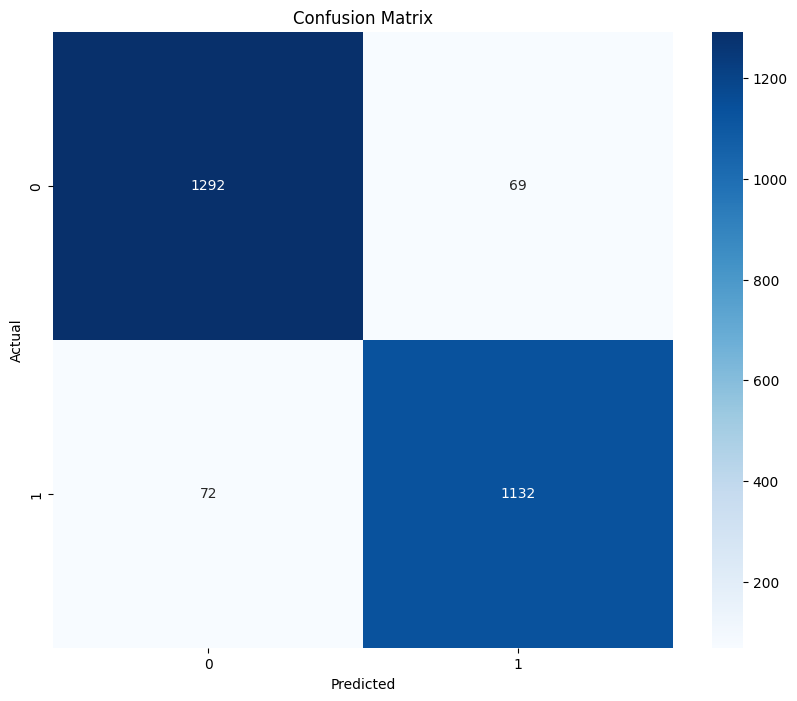

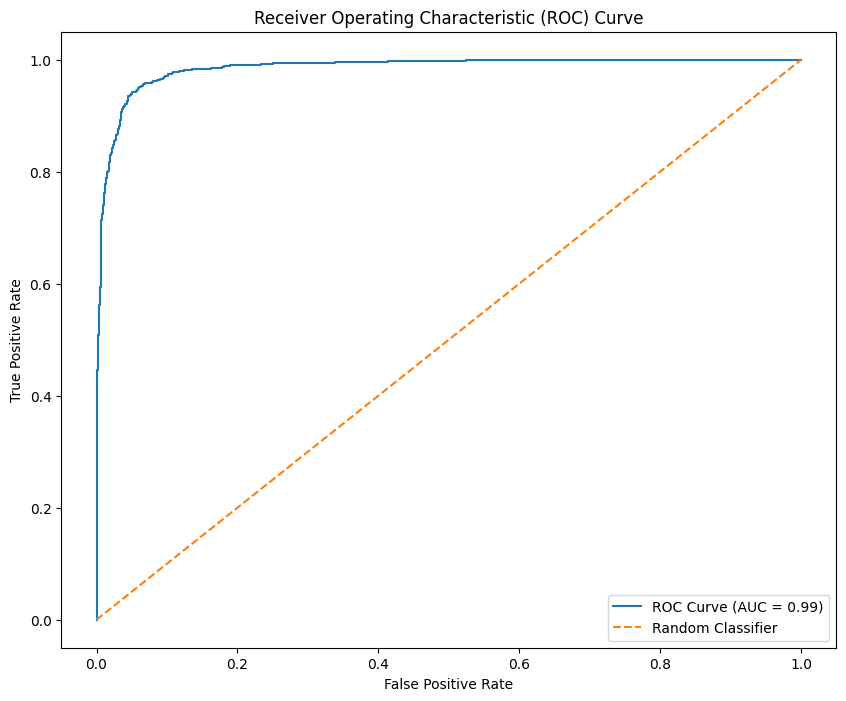

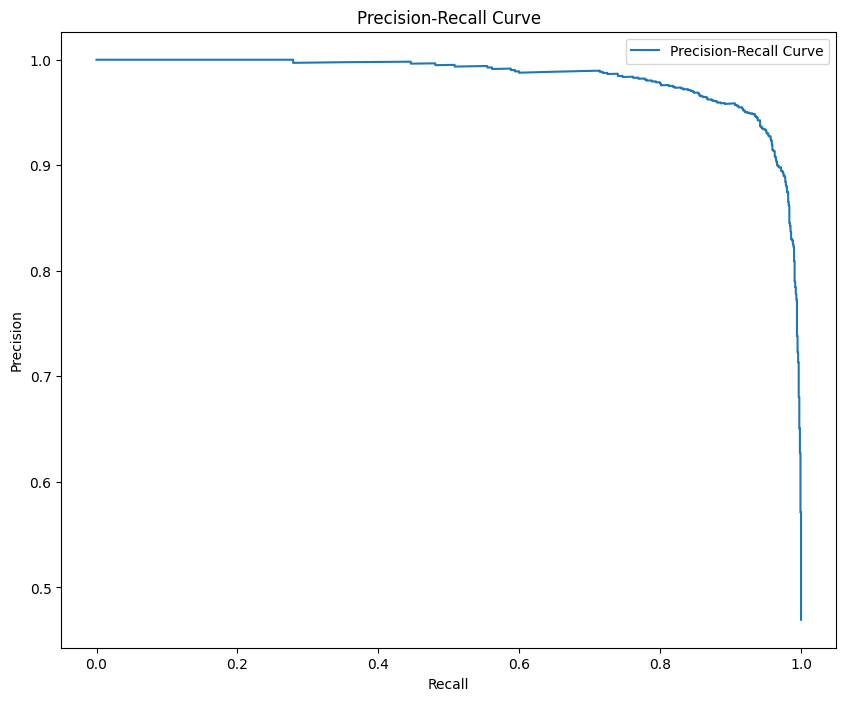

In [35]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

This code block defines a function for predicting the credibility of news articles and implements an interactive loop for real-time testing. The `predict_news_credibility` function preprocesses input text, applies the TF-IDF vectorizer, and uses the calibrated model to generate a credibility prediction and suspicion probability. The interactive loop allows users to input news articles, displays the model's predictions, and continues until the user chooses to quit, providing a practical interface for testing the news credibility classifier.

In [ ]:
# Function for advanced inference
def predict_news_credibility(text, vectorizer, model):
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    probability = model.predict_proba(vectorized_text)[0]
    
    suspicious_probability = probability[1]
    
    if suspicious_probability > 0.5:
        credibility = "Suspicious"
    else:
        credibility = "Credible"
    
    return credibility, suspicious_probability

# Interactive input for testing
while True:
    user_input = input("Enter a news article to check (or 'quit' to exit): ")
    if user_input.lower() == 'quit':
        break
    
    credibility, suspicious_probability = predict_news_credibility(user_input, tfidf, calibrated_model)
    print(f"Prediction: {credibility}")
    print(f"Probability of being suspicious: {suspicious_probability:.2f}")

print("Thank you for using the Fake News Detector!")

This code block saves the trained TF-IDF vectorizer and calibrated Naive Bayes model to separate files using joblib, allowing for easy reloading and reuse of the trained components in future applications without the need to retrain the model. The successful saving of these components is confirmed with a print statement.

In [37]:
# Save the vectorizer and calibrated model separately
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
joblib.dump(calibrated_model, 'calibrated_naivebayes_model.joblib')

print("Vectorizer and calibrated model saved successfully!")

Vectorizer and calibrated model saved successfully!
